# Graph neural networks

En este notebook explicaré un poco cómo es la estructura de los datos una vez transformados en grafos (tal y como nuestra red los va a tomar), cómo se crearía una red y cómo la entrenaríamos.

## Datos

### Donde están?

Estos datos en principio van a estar en el CESGA, que es donde tienes instalado el software que vas a necesitar. En tu cuenta, tienes 3 espacios:

* `$HOME`: espacio principal, donde puedes tener carpetas con tus notebooks por ejemplo
* `$LUSTRE`: espacio para archivos grandes, ahí tienes copiados todos los ficheros (probablemente más de los que necesites)
* `$STORE`: espacio de instalación de software, aquí en principio no deberías tocar nada

Para entrar en estos espacios puedes hacer `cd $LUSTRE` con el nombre del espacio que quieras.


En tu lustre tienes copiados los datos de distintas presiones, con la estructura `data/pressure/event_type/data_type/`. Además, en cada carpeta de presión tienes un fichero de la forma `dataset_pressure_graph_nn_all.pt` que contiene todos los eventos de esa presión, tanto doble-beta como 1 electrón, en la forma que la red neuronal los va a utilizar. Es decir, son los mismos eventos con los que trabajaste algo (aquí tenemos muchos más ficheros porque hay espacio), transformados como input de red. Vamos a ver un poco cómo son estos datos y luego ya vamos con la red.

### Qué son?

Recordemos que teníamos los `nexus`, que son eventos simulados, y están compuestos por todos los hits que deja en el detector la partícula cargada. Luego teníamos los ficheros etiquetados o `label`, que discretizaban el espacio en voxels y hacían un etiquetado según el voxel perteneciera a la traza, al blob, o a otra cosa. Con los ficheros `label` construimos los grafos para la red.

Para que te hagas una idea, un grafo es un objeto compuesto por 2 cosas: nodos y conexiones (nodes & edges). Los grafos sirven para representar muchas cosas de nuestro día a día; por ejemplo, una red social puede ser un gran grafo en el que cada nodo es un perfil, y las conexiones entre nodos son la amistad entre dos perfiles. Podemos extrapolar esto a nuestros datos: cada nodo es un voxel, y conectaremos los nodos que estén próximos.

### Veamos cómo es

Abrimos primero el fichero de `13bar` con los datos de grafos (tarda unos 3min20seg en abrir ya que es muy grande).


El fichero ya está preparado para la red, entonces tiene todos los eventos mezclados (son ~100k de `0nubb` y ~100k de `1eroi`), y divididos en 3 grupos: eventos para entrenar, para validar y para testear. Cuando entrenas una red, lo típico es dividir todos tus datos en esos tres grupos, utilizar los datos de `train` para entrenar, los de `validation` para controlar el entreno, y los de `test` para comprobar finalmente tus resultados. En este caso, los de `train` son el 80% de los eventos, `validation` un 10% y `test` el 10% restante.

In [59]:
import torch
import numpy as np
import pandas as pd

In [18]:
p = '13bar'

# la exclamación sirve para utilizar python como si fuera la línea de comandos en el bash
lustre_path = ! echo $LUSTRE

dataset_file = lustre_path[0] + '/data/{p}/dataset_{p}_graph_nn_all.pt'.format(p = p)

dataset = torch.load(dataset_file.format(p = p))
train_dataset, val_dataset, test_dataset = dataset

Vemos que cada objeto es un "Subset", que es un objeto de PyTorch, pero podemos ver qué tiene dentro si hacemos list():

In [22]:
train_dataset

In [21]:
list(train_dataset)

[Data(x=[161, 4], edge_index=[2, 586], edge_attr=[586, 2], y=[161, 1], edge_weight=[586], num_nodes=161, coords=[161, 3], dataset_id=21, binclass=0, fnum=1243),
 Data(x=[143, 4], edge_index=[2, 506], edge_attr=[506, 2], y=[143, 1], edge_weight=[506], num_nodes=143, coords=[143, 3], dataset_id=4, binclass=0, fnum=149),
 Data(x=[136, 4], edge_index=[2, 546], edge_attr=[546, 2], y=[136, 1], edge_weight=[546], num_nodes=136, coords=[136, 3], dataset_id=27, binclass=1, fnum=39),
 Data(x=[142, 4], edge_index=[2, 636], edge_attr=[636, 2], y=[142, 1], edge_weight=[636], num_nodes=142, coords=[142, 3], dataset_id=15, binclass=0, fnum=226),
 Data(x=[126, 4], edge_index=[2, 496], edge_attr=[496, 2], y=[126, 1], edge_weight=[496], num_nodes=126, coords=[126, 3], dataset_id=31, binclass=0, fnum=1447),
 Data(x=[163, 4], edge_index=[2, 580], edge_attr=[580, 2], y=[163, 1], edge_weight=[580], num_nodes=163, coords=[163, 3], dataset_id=40, binclass=0, fnum=84),
 Data(x=[125, 4], edge_index=[2, 468], ed

Escogemos un evento y vemos qué tiene:

In [23]:
event = list(train_dataset)[0]

Cada evento es un objeto `Data` con una serie de características guardadas (vectores/tensores) que te explico ahora:

In [25]:
event

Data(x=[161, 4], edge_index=[2, 586], edge_attr=[586, 2], y=[161, 1], edge_weight=[586], num_nodes=161, coords=[161, 3], dataset_id=21, binclass=0, fnum=1243)

* `x`: son los nodos del grafo. El tensor tiene una forma (N, F), siendo N el número de nodos/voxeles y F el número de características que le damos a cada nodo. En este caso tenemos 161 nodos y 4 características (este 4 va a ser siempre igual, y que cuando hice los datos decidí ponerle esas 4 caracteríticas). Estas son:
    * energía por voxel normalizada
    * numero de hits por voxel normalizados
    * energía por traza normalizada
    * numero de hits por traza normalizados

In [27]:
event.x

tensor([[2.0682e-03, 5.7471e-03, 1.0000e+00, 1.0000e+00],
        [2.5577e-03, 5.7471e-03, 1.0000e+00, 1.0000e+00],
        [7.3826e-03, 5.7471e-03, 1.0000e+00, 1.0000e+00],
        [2.9683e-03, 2.8736e-03, 1.0000e+00, 1.0000e+00],
        [4.3364e-03, 5.7471e-03, 1.0000e+00, 1.0000e+00],
        [2.3317e-03, 2.8736e-03, 1.0000e+00, 1.0000e+00],
        [3.0218e-03, 2.8736e-03, 1.0000e+00, 1.0000e+00],
        [2.7350e-03, 2.8736e-03, 1.0000e+00, 1.0000e+00],
        [2.7119e-03, 5.7471e-03, 1.0000e+00, 1.0000e+00],
        [4.3039e-03, 2.8736e-03, 1.0000e+00, 1.0000e+00],
        [8.3309e-03, 5.7471e-03, 1.0000e+00, 1.0000e+00],
        [6.5773e-03, 5.7471e-03, 1.0000e+00, 1.0000e+00],
        [4.2111e-03, 5.7471e-03, 1.0000e+00, 1.0000e+00],
        [3.0965e-03, 2.8736e-03, 1.0000e+00, 1.0000e+00],
        [4.8257e-03, 5.7471e-03, 1.0000e+00, 1.0000e+00],
        [4.0445e-03, 5.7471e-03, 1.0000e+00, 1.0000e+00],
        [3.7380e-03, 2.8736e-03, 1.0000e+00, 1.0000e+00],
        [5.671

* `edge_index`: son las conexiones de los nodos. El tensor tiene forma (2, E), siendo E el número de conexiones que hay. El tensor simplemente contiene pares de índices que dicen qué nodos están conectados, por ejemplo el nodo 0 con el 1, el 0 con el 2...

In [28]:
event.edge_index

tensor([[  0,   0,   0,  ..., 160, 160, 160],
        [  1,   2,   3,  ..., 155, 156, 159]])

* `edge_attr`: son las características de las conexiones. El tensor tiene forma (E, G), siendo E el número de conexiones que hay y G el número de características que le asigno (en este caso decidí asignarle dos, así que G=2 siempre). Estas son:
    * distancia entre nodos
    * gradiente de energía, dado por la fórmula |E_i - E_j| / d_ij, siendo i, j dos nodos, E la energía y d la distancia

In [30]:
event.edge_attr

tensor([[1.0000e+00, 4.8947e-04],
        [1.4142e+00, 3.7578e-03],
        [1.0000e+00, 9.0007e-04],
        ...,
        [1.0000e+00, 1.0900e-03],
        [1.4142e+00, 7.2572e-04],
        [1.0000e+00, 1.7326e-03]])

* `edge_weight`: son los pesos que le damos a las conexiones. El tensor tiene forma (E), así que a cada conexión se le asigna 1 peso. En este caso, los pesos son la inversa de la distancia (así cuanto más lejos estén dos nodos, más "débil" es esta conexión)

In [31]:
event.edge_weight

tensor([1.0000, 0.7071, 1.0000, 0.5774, 1.0000, 0.7071, 0.7071, 0.5774, 0.7071,
        1.0000, 0.7071, 1.0000, 1.0000, 0.7071, 1.0000, 0.7071, 0.7071, 1.0000,
        1.0000, 0.7071, 1.0000, 0.7071, 1.0000, 0.7071, 0.5774, 1.0000, 0.7071,
        1.0000, 0.7071, 0.5774, 0.7071, 1.0000, 0.7071, 0.5774, 1.0000, 1.0000,
        0.7071, 0.7071, 0.5774, 1.0000, 1.0000, 0.7071, 1.0000, 1.0000, 1.0000,
        1.0000, 0.7071, 1.0000, 1.0000, 0.7071, 0.7071, 1.0000, 1.0000, 0.7071,
        1.0000, 1.0000, 0.7071, 1.0000, 1.0000, 0.7071, 0.7071, 1.0000, 1.0000,
        0.7071, 0.7071, 1.0000, 0.5774, 1.0000, 0.7071, 1.0000, 1.0000, 0.7071,
        0.7071, 1.0000, 1.0000, 0.7071, 0.5774, 1.0000, 0.7071, 0.7071, 1.0000,
        0.5774, 1.0000, 0.7071, 0.7071, 1.0000, 0.7071, 0.7071, 1.0000, 1.0000,
        0.7071, 0.7071, 1.0000, 1.0000, 0.7071, 0.5774, 0.7071, 1.0000, 1.0000,
        0.7071, 1.0000, 0.7071, 1.0000, 0.5774, 0.7071, 1.0000, 1.0000, 0.7071,
        0.7071, 1.0000, 1.0000, 0.5774, 

* `y`: es la etiqueta de cada nodo, la segclass, y por tanto el tensor tiene forma (N, 1)

In [33]:
event.y

tensor([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [2],
        [2],
        [1],
        [1],
        [1],
        [1],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [1],
        [1],
        [1],
        [0],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [1],
        [1],
        [1],
        [1],
        [2],
        [2],
        [2],
        [2],
        [1],

Otras características:

* `num_nodes`: el numero de nodos
* `coords`: las coordenadas de cada nodo, como los voxeles, que no se usan directamente en la red pero ayudan a saber cual es cada nodo
* `binclass`: si el evento es señal o fondo
* `dataset_id`: numero de evento
* `fnum`: numero de fichero

Estas dos últimas junto con `binclass` sirven para poder ir al fichero original y ver más información del evento si hiciera falta, por ejemplo en este caso:

In [42]:
dt = '1eroi' if event.binclass == 0 else '0nubb'
nfile = event.fnum

label_file = lustre_path[0] + '/data/{p}/{dt}/label/prod/nexus_label_{nfile}_{dt}.h5'.format(p = p, dt = dt, nfile = nfile)

In [48]:
dataset_id = event.dataset_id

voxel_df = pd.read_hdf(label_file, 'DATASET/MCVoxels')
voxel = voxel_df[voxel_df.dataset_id == dataset_id]

Pudimos con esta información obtener el dataframe original (vemos que el número de nodos 161 coincide con el número de voxeles para este evento, lo cual tiene sentido)

In [49]:
voxel

,x,y,z,ener,ratio,segclass,nhits,binclass,dataset_id,elem_ener,elem,elem_count,cloud_ener,cloud,cloud_count,nblob,blob_success
3193,62,164,308,0.005084,1.0,2,2,0,21,0.482080,2_1,2.0,2.458,c_0,1.0,1,True
3194,62,164,309,0.006287,1.0,2,2,0,21,0.482080,2_1,2.0,2.458,c_0,1.0,1,True
3195,62,165,307,0.018146,1.0,2,2,0,21,0.482080,2_1,2.0,2.458,c_0,1.0,1,True
3196,62,165,308,0.007296,1.0,2,1,0,21,0.482080,2_1,2.0,2.458,c_0,1.0,1,True
3197,62,166,306,0.010659,1.0,2,2,0,21,0.482080,2_1,2.0,2.458,c_0,1.0,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3349,112,132,319,0.012146,1.0,2,2,0,21,1.125614,2_0,2.0,2.458,c_0,1.0,1,True
3350,112,133,319,0.011247,1.0,2,2,0,21,1.125614,2_0,2.0,2.458,c_0,1.0,1,True
3351,112,134,319,0.005498,1.0,2,1,0,21,1.125614,2_0,2.0,2.458,c_0,1.0,1,True
3352,113,130,319,0.005365,1.0,2,1,0,21,1.125614,2_0,2.0,2.458,c_0,1.0,1,True


## Neural network

Vamos a ver ahora cómo se construye una red neuronal con Pytorch. Las redes neuronales se construyen utilizando clases. Una clase en python es como un objeto sobre el cual puedes ir añadiendo características, formas de actuar, etc... 

### Ejemplo de una clase

Para que te hagas una idea, puedo crear una clase que sea un vector. En python para eso ya están los arrays, pero imagínate que no existiera el array con las características que tú quieres, pues te creas tu propia clase y defines cómo quiere que opere:

In [91]:
class vector():
    #lo primero que hay que hacer es definir el __init__. Todo lo que metas aquí va a suceder en cuanto crees tu clase, por decirlo así. Aquí puedes definir variables, y otras cosas.
    # El primer argumento es self, y todo lo que definas y quieras usar en otras partes tiene que venir dado por self
    # A mayores añador el argumento valores, que va a ser una lista con los valores que quiero para mi vector
    def __init__(self, valores):
        self.valores = valores

    # ahora voy a crearle una característica, que es que me sume todos los elementos
    def suma(self):
        suma = 0
        for val in self.valores:
            suma += val
        return suma
    # y podemos añadir más, como que haga el cuadrado de cada valor
    def cuadrado(self):
        cuadrado = []
        for val in self.valores:
            cuadrado.append(val*val)
        return cuadrado

    # combinando estos dos podemos hacer la norma del vector!
    # tenemos que coger la clase vector, meterle los valores y aplicar la función cuadrado; luego ese resultado se mete otra vez en la clase vector y se le aplica suma, y ya estaría
    def norma(self):
        cuadrado = vector(self.valores).cuadrado()
        suma_cuad = vector(cuadrado).suma()
        return np.sqrt(suma_cuad)
    
    #tambien por ejemplo normalizar
    def normalizar(self):
        norma = vector(self.valores).norma()
        normaliz = []
        for val in self.valores:
            normaliz.append(val / norma)
        return normaliz

    # o sumar un valor a todos los elementos
    def sumar_numero(self, numero):
        nuevo_vector = []
        for val in self.valores:
            nuevo_vector.append(val + numero)
        return nuevo_vector


Mira como se usa, construyo mi vector metiéndole una lista de valores:

In [77]:
valores = [2, 3, 4]

mi_vector = vector(valores)

La variable `mi_vector` ahora es un objeto que contiene los valores que yo le di, y va a actuar con ellos según yo definí en las funciones internas!

In [79]:
mi_vector

Puedo acceder a sus valores gracias a lo que definí en el __ init __:

In [81]:
mi_vector.valores

[2, 3, 4]

Puedo hacer su suma, cuadrado, norma, normalizar, sumar un numero:

In [82]:
mi_vector.suma()

9

In [83]:
mi_vector.cuadrado()

[4, 9, 16]

In [84]:
mi_vector.norma()

5.385164807134504

In [85]:
mi_vector.normalizar()

[0.3713906763541037, 0.5570860145311556, 0.7427813527082074]

In [90]:
mi_vector.sumar_numero(3)

[5, 6, 7]

### Clase de red neuronal

La clase de red neuronal no es muy complicada. Tiene la parte del init dónde vas a inicializar las operaciones que hace la red, y la parte de forward dónde le vas  a decir a tus datos cómo pasar por las operaciones, en qué orden.

Las operaciones (también llamadas layers, como capas de cálculo de tu red) no las tienes que hacer tu, ya vienen en pytorch, tú lo que tienes que hacer es decidir qué caracteríticas quieres que tengan y el orden.

Para que veas, esta sería un ejemplo (sin nada dentro) de las líneas de código de una red

In [92]:
class my_net(torch.nn.Module):
    #primero el init, donde tendrás que añadir más argumentos si los necesitas
    def __init__(self):
        #esta línea déjala así, solo cambia my_net si cambias el nombre de tu clase
        super(my_net, self).__init__()

        #crea aquí tus operaciones

    def forward(self, data):
        #Extraenis los distintos datos de el objeto Data
        x, edge_index, edge_weight, batch = data.x, data.edge_index, data.edge_weight, data.batch
        #di aquí qué orden quieres hacer pasar los datos
        
        return x

### Ejemplo de estructura

Una estructura de clasificación (que nos dice si un evento es señal o fondo) podría ser esta:

![Captura de pantalla 2024-04-19 a las 13.31.12.png](<attachment:Captura de pantalla 2024-04-19 a las 13.31.12.png>)
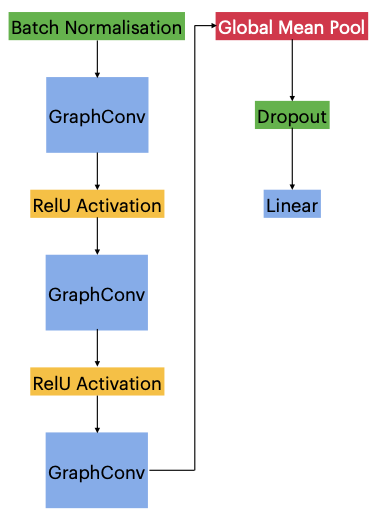

Son una serie de convoluciones (hablamos si quieres de qué es esto y cómo funciona) que se hacen a todos los nodos de la red, con otras operaciones intercaladas para asegurar que la red sea estable (podemos tb hablar algo de esto en persona), y finalmente una global mean pool.

Las convoluciones son operaciones en las que la información (las características que teníamos por cada nodo) viaja a través de las conexiones hacia los nodos vecinos. Además, en cada convolución, podemos aumentar el número de características. Qué son esas nuevas características? Eso no lo sabemos, es cosa de la red. Quizá una nueva característica es pues lo "central" que es un nodo, o lo "importante" que es dentro del grafo, u otras cosas. Es más fácil de entender con otros ejemplos, pero bueno, esto es el funcionamiento básico de muchos tipos de redes neuronales.

La global mean pool simplemente nos reduce el evento de N nodos a sólo 1 "nodo", o más bien, a una representación "evento a evento". Esto tb lo podemos hablar para que entiendas.

### Operaciones en la red

In [93]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.nn import BatchNorm

#### Convolucion

Podemos empezar viendo cómo es la convolución. En Pytorch geometric está documentado qué es lo que nos pide (https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.GCNConv.html), veamos:

Puedes ver que la tenemos que inicializar como mínimo con el número de características con las que entra y con las que sale:

In [96]:
conv = GCNConv(4, 8)

La variable `conv` es una convolución a la que le van a entrar 4 features (las 4 de cada nodo, recuerdas?) y van a salir 8 (son features que la propia red "busca", por así decirlo)

Una vez está inicializada, nos dice que le podemos hacer pasar como input:
* Node features: es nuestro `x`, con forma (N, F) (en la documentacion aparece que N es |V| y F es F_in, cosas de la notación) 
* Edge indices: nuestro `edge_index`, con forma (2, E)
* Edge weights: nuestro `edge_weight`, con forma (E), y es opcional (si no se lo das, todas las conexiones valen lo mismo)

In [98]:
x, edge_index, edge_weight = event.x, event.edge_index, event.edge_weight

out = conv(x, edge_index, edge_weight)

Y como salida obtenemos un nuevo `x`, con más features, en concreto 8, y el mismo número de nodos!

In [100]:
out.shape

torch.Size([161, 8])

#### Pooling

Pool aquí no es piscina, significa "agrupar". Esta operación va a agrupar todos los nodos en uno solo, que debería ser una representación del evento por completo, por así decirlo. Puedes ver en la documentación cómo es: https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.pool.global_mean_pool.html

En este caso, la operación es sencilla y hace una media de cada feature de todos los nodos, por lo que si cogemos el output de la anterior convolución, con forma (N, 8), al pasarla por aquí tendremos un output de (1, 8):

In [106]:
pooled_out = global_mean_pool(out, batch = None)
pooled_out

tensor([[ 0.9943,  0.1951,  0.7175, -0.8057, -0.6449, -0.0701, -0.1197, -1.1734]],
       grad_fn=<MeanBackward1>)

Lo de batch ahora mismo es None porque estamos con un solo evento, pero lo típico es pasar a la red grupos de eventos (batches), entonces hay un vector que se crea automáticamente que le dice a la red cuales son los nodos que van juntos y por tanto pertenecen a un mismo evento. Ya se verá más adelante cuando haga falta.

Efectivamente, nuestro evento de 161 nodos se reduce a 1 vector con 8 features; solo nos queda un último paso.

#### Linear

Lo que queremos finalmente es que para cada evento nos diga si es señal o fondo. Hay dos formas equivalentes de hacerlo, y son muy parecidas. Yo me decanto siempre por la que te voy a enseñar, porque sirve más que para una clasificación binaria. Es decir, es extendible a N clases (en este ejemplo solo hay 2, pero podría haber más, podría ser que hubiera señal, fondo, y más cosas!)

Por tanto, lo último que se hace es aplicar una transformación lineal al vector que representa nuestro evento (https://pytorch.org/docs/stable/generated/torch.nn.Linear.html). Similar a la convolución, te pide primero que le digas cual es el número de features de entrada (8 en este caso) y de salida. 

Para el final de la red, lo que vamos a querer van a ser DOS features: una que nos dice la probabilidad de que el evento sea de fondo, y otra la probabilidad de que sea señal. Entonces:

In [105]:
lin = nn.Linear(8, 2)

La variable `lin` ya contiene la operación lineal, ahora solo falta pasarle el tensor que teníamos:

In [108]:
final_out = lin(pooled_out)
final_out

tensor([[-0.2842,  0.4455]], grad_fn=<AddmmBackward0>)

Lo pasamos a probabilidades utilizando la función softmax:

In [113]:
#inicializamos
softmax = nn.Softmax(dim = 1)

#pasamos el vector
prob = softmax(final_out)
prob

tensor([[0.3252, 0.6748]], grad_fn=<SoftmaxBackward0>)

Podríamos interpretar esto entonces como:

In [125]:
print('Hay un {}% de posibilidades de que el evento sea de fondo'.format(prob[0, 0]*100))
print('Hay un {}% de posibilidades de que el evento sea de señal'.format(prob[0, 1]*100))

Hay un 32.524993896484375% de posibilidades de que el evento sea de fondo
Hay un 67.47500610351562% de posibilidades de que el evento sea de señal


Es decir, asignamos que la feature en la posición 0 represente al fondo, y en la posicion 1 a la señal. Si esto en vez de eventos fueran fotos de animales, y hubiera 4 animales posibles, tendríamos que asignar al tensor de 4 posiciones una posicion por animal, por ejemplo [perro, gato, caballo, pato]

### Crear la red

Con estos fundamentos se puede hacer una red sencilla, juntando una convolución tras otra, haciendo pooling y finalmente hacer la operación lineal (o las operaciones, no tiene por que ser solamente una)

### Entrenar la red

Una vez se crea la red hay que entrenarla, voy a explicar un poco en qué consiste para que tengas una idea, pero mejor que los tutoriales que te pasé no creo que lo explique. Aun así hago un resumen con las cosas que tenemos ya a la vista, que es más tangible.

La salida de la red es, por cada evento, una dupla de números [a, b] que representan lo cercano que está de ser mi evento a cada una de las clases (a para fondo, b para señal). Entonces, por cada salida, tenemos que cuantificar lo "acertados" que estamos, y para eso se usa lo que llamamos una "función de pérdida" o "loss function".

#### Loss function

El ejemplo más sencillo es una simple resta. Sabemos que el evento que estamos usando:

In [127]:
dt

'1eroi'

Es decir, un evento de fondo (1eroi). Por tanto, lo ideal sería que nuestra red diera la salida [1, 0] (es decir, 100% posibilidades de que sea fondo, y 0% de que sea señal). Una simple resta nos daría lo que se aleja nuestro resultado de ser fondo:

In [131]:
(1 - prob)[0, 0].item()

0.6747500896453857

Y eso es lo que se llama pérdida, que se intentará minimizar. Para minimizarla, se hace lo que se llama la "backpropagation", que a grandes rasgos va calculando los gradientes  en todos los parámetros de la red.

#### Optimizer

El último paso es actualizar los parámetros de la red, y para ello se utiliza la figura del "optimizer". Una vez se actualizan, se repite todo este proceso, procurando disminuir cada vez más la pérdida o loss.